### Importing essential libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

### Import the Cleaned Instagram Dataset 

In [2]:
data = pd.read_csv("Datasets/cleaned-IG-data.csv", encoding = "utf-8",sep=",")

In [3]:
data = data.drop('Unnamed: 0', axis = 1)
data

,Impressions,Comments,Shares,Likes,Caption,Hashtags,fullCaption,Tokenized_Text,Stemmed_Text,tokenizedCaptions
0,3920,9,5,162,Here are some of the most important data visua...,#finance #money #business #investing #investme...,here are some of the most important data visua...,"['important', 'data', 'visualizations', 'every...","['import', 'data', 'visual', 'everi', 'financi...","['important', 'data', 'visualization', 'every'..."
1,5394,7,14,224,Here are some of the best data science project...,#healthcare #health #covid #data #datascience ...,here are some of the best data science project...,"['best', 'data', 'science', 'project', 'ideas'...","['best', 'data', 'scienc', 'project', 'idea', ...","['best', 'data', 'science', 'project', 'idea',..."
2,4021,11,1,131,Learn how to train a machine learning model an...,#data #datascience #dataanalysis #dataanalytic...,learn how to train a machine learning model an...,"['learn', 'train', 'machine', 'learning', 'mod...","['learn', 'train', 'machin', 'learn', 'model',...","['learn', 'train', 'machine', 'learning', 'mod..."
3,4528,10,7,213,Heres how you can write a Python program to d...,#python #pythonprogramming #pythonprojects #py...,heres how you can write a python program to d...,"['heres', 'write', 'python', 'program', 'detec...","['here', 'write', 'python', 'program', 'detect...","['here', 'write', 'python', 'program', 'detect..."
4,2518,5,4,123,Plotting annotations while visualizing your da...,#datavisualization #datascience #data #dataana...,plotting annotations while visualizing your da...,"['plotting', 'annotations', 'visualizing', 'da...","['plot', 'annot', 'visual', 'data', 'consid', ...","['plotting', 'annotation', 'visualizing', 'dat..."
...,...,...,...,...,...,...,...,...,...,...
114,13700,2,38,373,Here are some of the best data science certifi...,#datascience #datasciencejobs #datasciencetrai...,here are some of the best data science certifi...,"['best', 'data', 'science', 'certifications', ...","['best', 'data', 'scienc', 'certif', 'choos', ...","['best', 'data', 'science', 'certification', '..."
115,5731,4,1,148,Clustering is a machine learning technique use...,#machinelearning #machinelearningalgorithms #d...,clustering is a machine learning technique use...,"['clustering', 'machine', 'learning', 'techniq...","['cluster', 'machin', 'learn', 'techniqu', 'us...","['clustering', 'machine', 'learning', 'techniq..."
116,4139,0,1,92,Clustering music genres is a task of grouping ...,#machinelearning #machinelearningalgorithms #d...,clustering music genres is a task of grouping ...,"['clustering', 'music', 'genres', 'task', 'gro...","['cluster', 'music', 'genr', 'task', 'group', ...","['clustering', 'music', 'genre', 'task', 'grou..."
117,32695,2,75,549,Here are some of the best data science certifi...,#datascience #datasciencejobs #datasciencetrai...,here are some of the best data science certifi...,"['best', 'data', 'science', 'certifications', ...","['best', 'data', 'scienc', 'certif', 'choos', ...","['best', 'data', 'science', 'certification', '..."


### Bootstrapping the current dataset

In [4]:
# Number of bootstrap samples to generate 
n_samples = 20

# Function to bootstrap data 
def bootstrap_data(df, n_samples):
    bootstrap_samples = []
    # Loop to generate bootstrap samples 
    for i in range(n_samples):
        # Create an empty DataFrame for each bootstrap sample 
        bootstrap_sample = pd.DataFrame()
        # Loop through each column in the original DataFrame 
        for column in df.columns:
            # Sample with replacement from each column and reset index 
            sample = df[column].sample(n=len(df), replace=True, random_state=1000).reset_index(drop=True)
            # Add the sampled column to the bootstrap sample DataFrame 
            bootstrap_sample[column] = sample
        # Append the bootstrap sample to the list of bootstrap samples 
        bootstrap_samples.append(bootstrap_sample)
    # Return the list of bootstrap samples 
    return bootstrap_samples

# Generate bootstrap samples using the bootstrap_data function 
bootstrap_samples = bootstrap_data(data, n_samples)

# Concatenate the original data with each bootstrap sample 
for bootstrap_sample in bootstrap_samples:
    # Concatenate the original data with the current bootstrap sample 
    data = pd.concat([data, bootstrap_sample], ignore_index=True)

data

,Impressions,Comments,Shares,Likes,Caption,Hashtags,fullCaption,Tokenized_Text,Stemmed_Text,tokenizedCaptions
0,3920,9,5,162,Here are some of the most important data visua...,#finance #money #business #investing #investme...,here are some of the most important data visua...,"['important', 'data', 'visualizations', 'every...","['import', 'data', 'visual', 'everi', 'financi...","['important', 'data', 'visualization', 'every'..."
1,5394,7,14,224,Here are some of the best data science project...,#healthcare #health #covid #data #datascience ...,here are some of the best data science project...,"['best', 'data', 'science', 'project', 'ideas'...","['best', 'data', 'scienc', 'project', 'idea', ...","['best', 'data', 'science', 'project', 'idea',..."
2,4021,11,1,131,Learn how to train a machine learning model an...,#data #datascience #dataanalysis #dataanalytic...,learn how to train a machine learning model an...,"['learn', 'train', 'machine', 'learning', 'mod...","['learn', 'train', 'machin', 'learn', 'model',...","['learn', 'train', 'machine', 'learning', 'mod..."
3,4528,10,7,213,Heres how you can write a Python program to d...,#python #pythonprogramming #pythonprojects #py...,heres how you can write a python program to d...,"['heres', 'write', 'python', 'program', 'detec...","['here', 'write', 'python', 'program', 'detect...","['here', 'write', 'python', 'program', 'detect..."
4,2518,5,4,123,Plotting annotations while visualizing your da...,#datavisualization #datascience #data #dataana...,plotting annotations while visualizing your da...,"['plotting', 'annotations', 'visualizing', 'da...","['plot', 'annot', 'visual', 'data', 'consid', ...","['plotting', 'annotation', 'visualizing', 'dat..."
...,...,...,...,...,...,...,...,...,...,...
2494,4115,6,3,191,Here are two best ways to count the number of ...,#python #pythonprogramming #pythonprojects #py...,here are two best ways to count the number of ...,"['two', 'best', 'ways', 'count', 'number', 'le...","['two', 'best', 'way', 'count', 'number', 'let...","['two', 'best', 'way', 'count', 'number', 'let..."
2495,2621,5,1,76,Learn how to analyze a candlestick chart as a ...,#stockmarket #investing #stocks #trading #mone...,learn how to analyze a candlestick chart as a ...,"['learn', 'analyze', 'candlestick', 'chart', '...","['learn', 'analyz', 'candlestick', 'chart', 'd...","['learn', 'analyze', 'candlestick', 'chart', '..."
2496,5055,7,11,159,"In Data Science, Time Series Analysis is a met...",#timeseries #time #statistics #datascience #bi...,"in data science, time series analysis is a met...","['data', 'science', 'time', 'series', 'analysi...","['data', 'scienc', 'time', 'seri', 'analysi', ...","['data', 'science', 'time', 'series', 'analysi..."
2497,11068,7,8,250,Here are some of the best data science project...,#data #datascience #dataanalysis #dataanalytic...,here are some of the best data science project...,"['best', 'data', 'science', 'project', 'ideas'...","['best', 'data', 'scienc', 'project', 'idea', ...","['best', 'data', 'science', 'project', 'idea',..."


The variable 'data' now contains the original data concatenated with all bootstrap samples 

### Exploring numerical variables of Dataset 

In [5]:
# Reindex the DataFrame 
data = data.reindex()

In [6]:
# Extract list of columns
data_cols = list(data.columns)
print('Dataset columns: {}'.format(data_cols))

Dataset columns: ['Impressions', 'Comments', 'Shares', 'Likes', 'Caption', 'Hashtags', 'fullCaption', 'Tokenized_Text', 'Stemmed_Text', 'tokenizedCaptions']


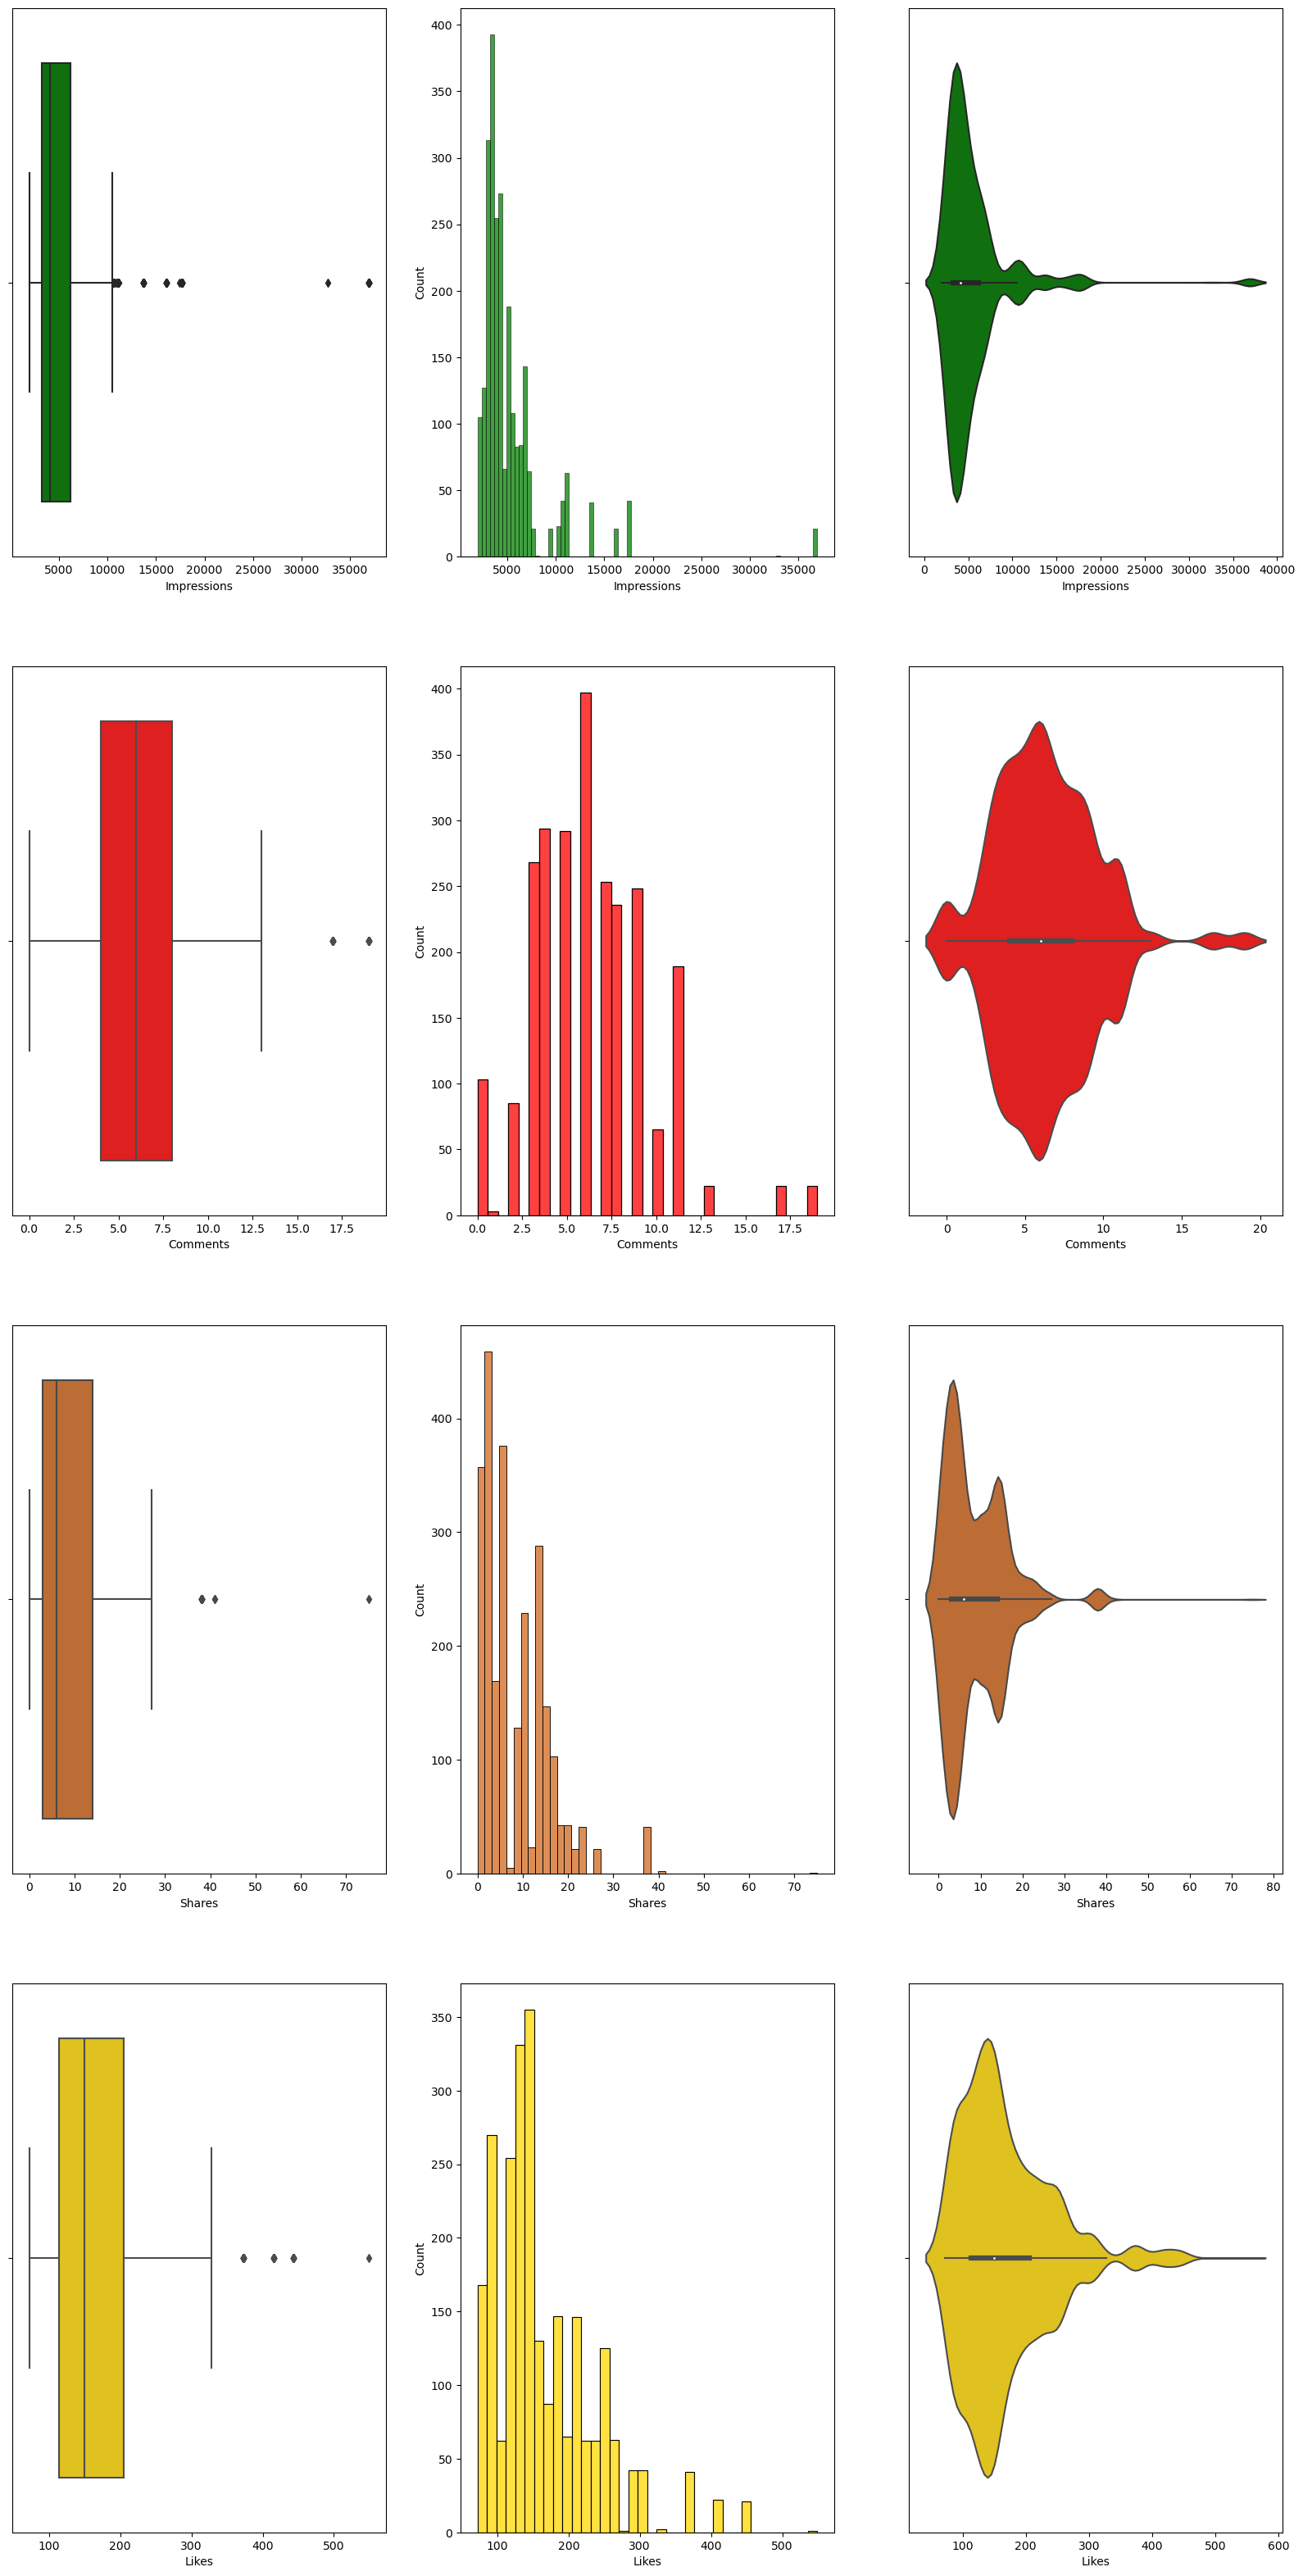

In [8]:
# Draw the distribution of numerical variables 
f, axes = plt.subplots(4,3, figsize=(20,40))
colours = ['green', 'red', 'chocolate', 'gold']

count = 0
for i in range(4):
    sb.boxplot(x = data[data_cols[i]], orient = 'h', color = colours[count], ax = axes[count,0])
    sb.histplot(x = data[data_cols[i]], color = colours[count], ax = axes[count,1])
    sb.violinplot(x = data[data_cols[i]], color = colours[count], ax = axes[count,2])
    count+=1

### Cleaning the numerical variables of Dataset 

Once we are done with the basic exploration of numerical variables, it's time to clean and tidy-up the dataset. This is done by identifying and removing outliers from the data.

Impressions    210
Comments        44
Shares          44
Likes           85
dtype: int64

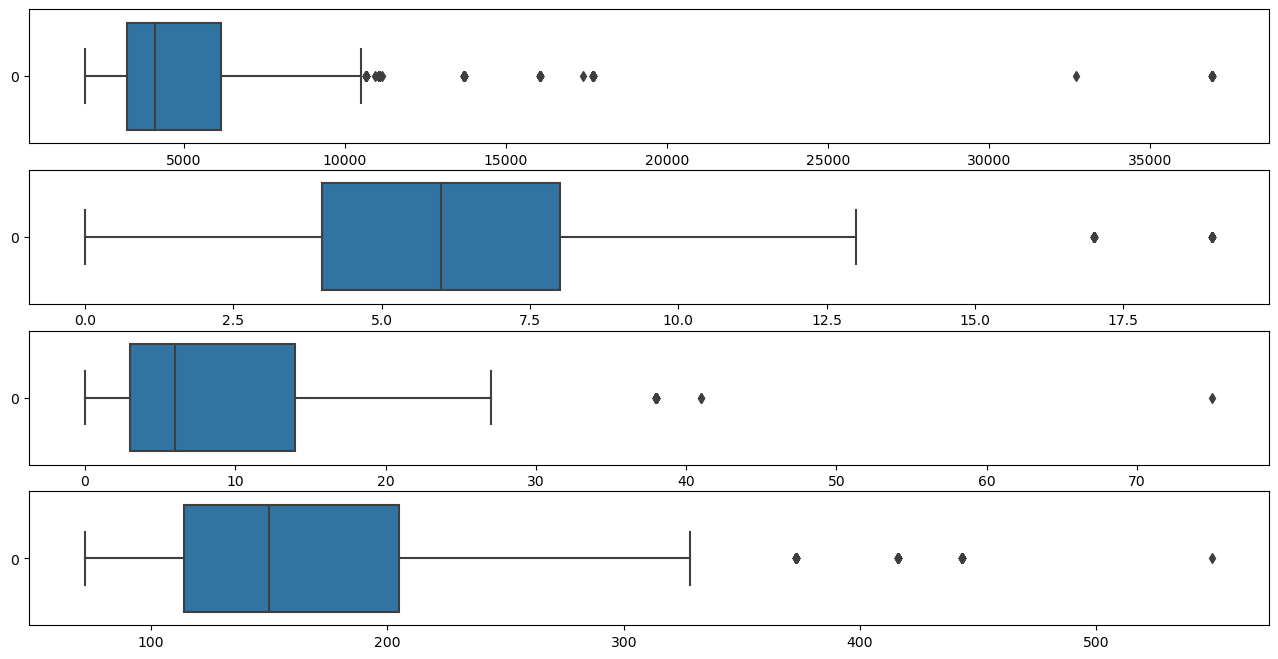

In [ ]:
# Extract the two variables
targetData = data[['Impressions', 'Comments','Shares', 'Likes']].copy()
# Make a clean "copy" and not just a slice of the dataset

# Draw the boxplots
f, axes = plt.subplots(4, 1, figsize=(16, 8))

sb.boxplot(data = targetData["Impressions"], orient = "h", ax = axes[0])
sb.boxplot(data = targetData["Comments"], orient = "h", ax = axes[1])
sb.boxplot(data = targetData["Shares"], orient = "h", ax = axes[2])
sb.boxplot(data = targetData["Likes"], orient = "h", ax = axes[3])


# Calculate the quartiles
Q1 = targetData.quantile(0.25)
Q3 = targetData.quantile(0.75)

# Rule to identify outliers
rule = ((targetData < (Q1 - 1.5 * (Q3 - Q1))) | (targetData > (Q3 + 1.5 * (Q3 - Q1))))

# Count the number of outliers
rule.sum()

In [ ]:
# Calculate the quartiles
Q1 = targetData.quantile(0.25)
Q3 = targetData.quantile(0.75)

# Rule to identify outliers
rule = ((targetData < (Q1 - 1.5 * (Q3 - Q1))) | (targetData > (Q3 + 1.5 * (Q3 - Q1))))

# Check the dataframe rule
rule

,Impressions,Comments,Shares,Likes
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
2494,False,False,False,False
2495,False,False,False,False
2496,False,False,False,False
2497,True,False,False,False


In [ ]:
# Find the rows where ANY column is True
outliers = rule.any(axis = 1)   # axis 0 is row, 1 is column

# Check the outliers -- it's a boolean Series
outliers


0       False
1       False
2       False
3       False
4       False
        ...  
2494    False
2495    False
2496    False
2497     True
2498    False
Length: 2499, dtype: bool

In [ ]:
outlierindices = outliers.index[outliers == True]
outlierindices

Index([  16,   26,   40,   49,   54,   67,   83,   90,   95,  105,
       ...
       2397, 2404, 2406, 2408, 2431, 2434, 2444, 2455, 2473, 2497],
      dtype='int64', length=256)

In [ ]:
# Remove the outliers based on the row indices obtained above
data.drop(axis = 0,               # 0 drops row 1 drops column
                index = outlierindices, # this takes a list as input
                inplace = True)         # not overwritten by default 

# Check the clean data
data

,Impressions,Comments,Shares,Likes,Caption,Hashtags,fullCaption,Tokenized_Text,Stemmed_Text,tokenizedCaptions
0,3920,9,5,162,Here are some of the most important data visua...,#finance #money #business #investing #investme...,here are some of the most important data visua...,"['important', 'data', 'visualizations', 'every...","['import', 'data', 'visual', 'everi', 'financi...","['important', 'data', 'visualization', 'every'..."
1,5394,7,14,224,Here are some of the best data science project...,#healthcare #health #covid #data #datascience ...,here are some of the best data science project...,"['best', 'data', 'science', 'project', 'ideas'...","['best', 'data', 'scienc', 'project', 'idea', ...","['best', 'data', 'science', 'project', 'idea',..."
2,4021,11,1,131,Learn how to train a machine learning model an...,#data #datascience #dataanalysis #dataanalytic...,learn how to train a machine learning model an...,"['learn', 'train', 'machine', 'learning', 'mod...","['learn', 'train', 'machin', 'learn', 'model',...","['learn', 'train', 'machine', 'learning', 'mod..."
3,4528,10,7,213,Heres how you can write a Python program to d...,#python #pythonprogramming #pythonprojects #py...,heres how you can write a python program to d...,"['heres', 'write', 'python', 'program', 'detec...","['here', 'write', 'python', 'program', 'detect...","['here', 'write', 'python', 'program', 'detect..."
4,2518,5,4,123,Plotting annotations while visualizing your da...,#datavisualization #datascience #data #dataana...,plotting annotations while visualizing your da...,"['plotting', 'annotations', 'visualizing', 'da...","['plot', 'annot', 'visual', 'data', 'consid', ...","['plotting', 'annotation', 'visualizing', 'dat..."
...,...,...,...,...,...,...,...,...,...,...
2493,4467,3,16,149,Here are some of the popular applications of d...,#data #datascience #dataanalysis #dataanalytic...,here are some of the popular applications of d...,"['popular', 'applications', 'data', 'science',...","['popular', 'applic', 'data', 'scienc', 'finan...","['popular', 'application', 'data', 'science', ..."
2494,4115,6,3,191,Here are two best ways to count the number of ...,#python #pythonprogramming #pythonprojects #py...,here are two best ways to count the number of ...,"['two', 'best', 'ways', 'count', 'number', 'le...","['two', 'best', 'way', 'count', 'number', 'let...","['two', 'best', 'way', 'count', 'number', 'let..."
2495,2621,5,1,76,Learn how to analyze a candlestick chart as a ...,#stockmarket #investing #stocks #trading #mone...,learn how to analyze a candlestick chart as a ...,"['learn', 'analyze', 'candlestick', 'chart', '...","['learn', 'analyz', 'candlestick', 'chart', 'd...","['learn', 'analyze', 'candlestick', 'chart', '..."
2496,5055,7,11,159,"In Data Science, Time Series Analysis is a met...",#timeseries #time #statistics #datascience #bi...,"in data science, time series analysis is a met...","['data', 'science', 'time', 'series', 'analysi...","['data', 'scienc', 'time', 'seri', 'analysi', ...","['data', 'science', 'time', 'series', 'analysi..."


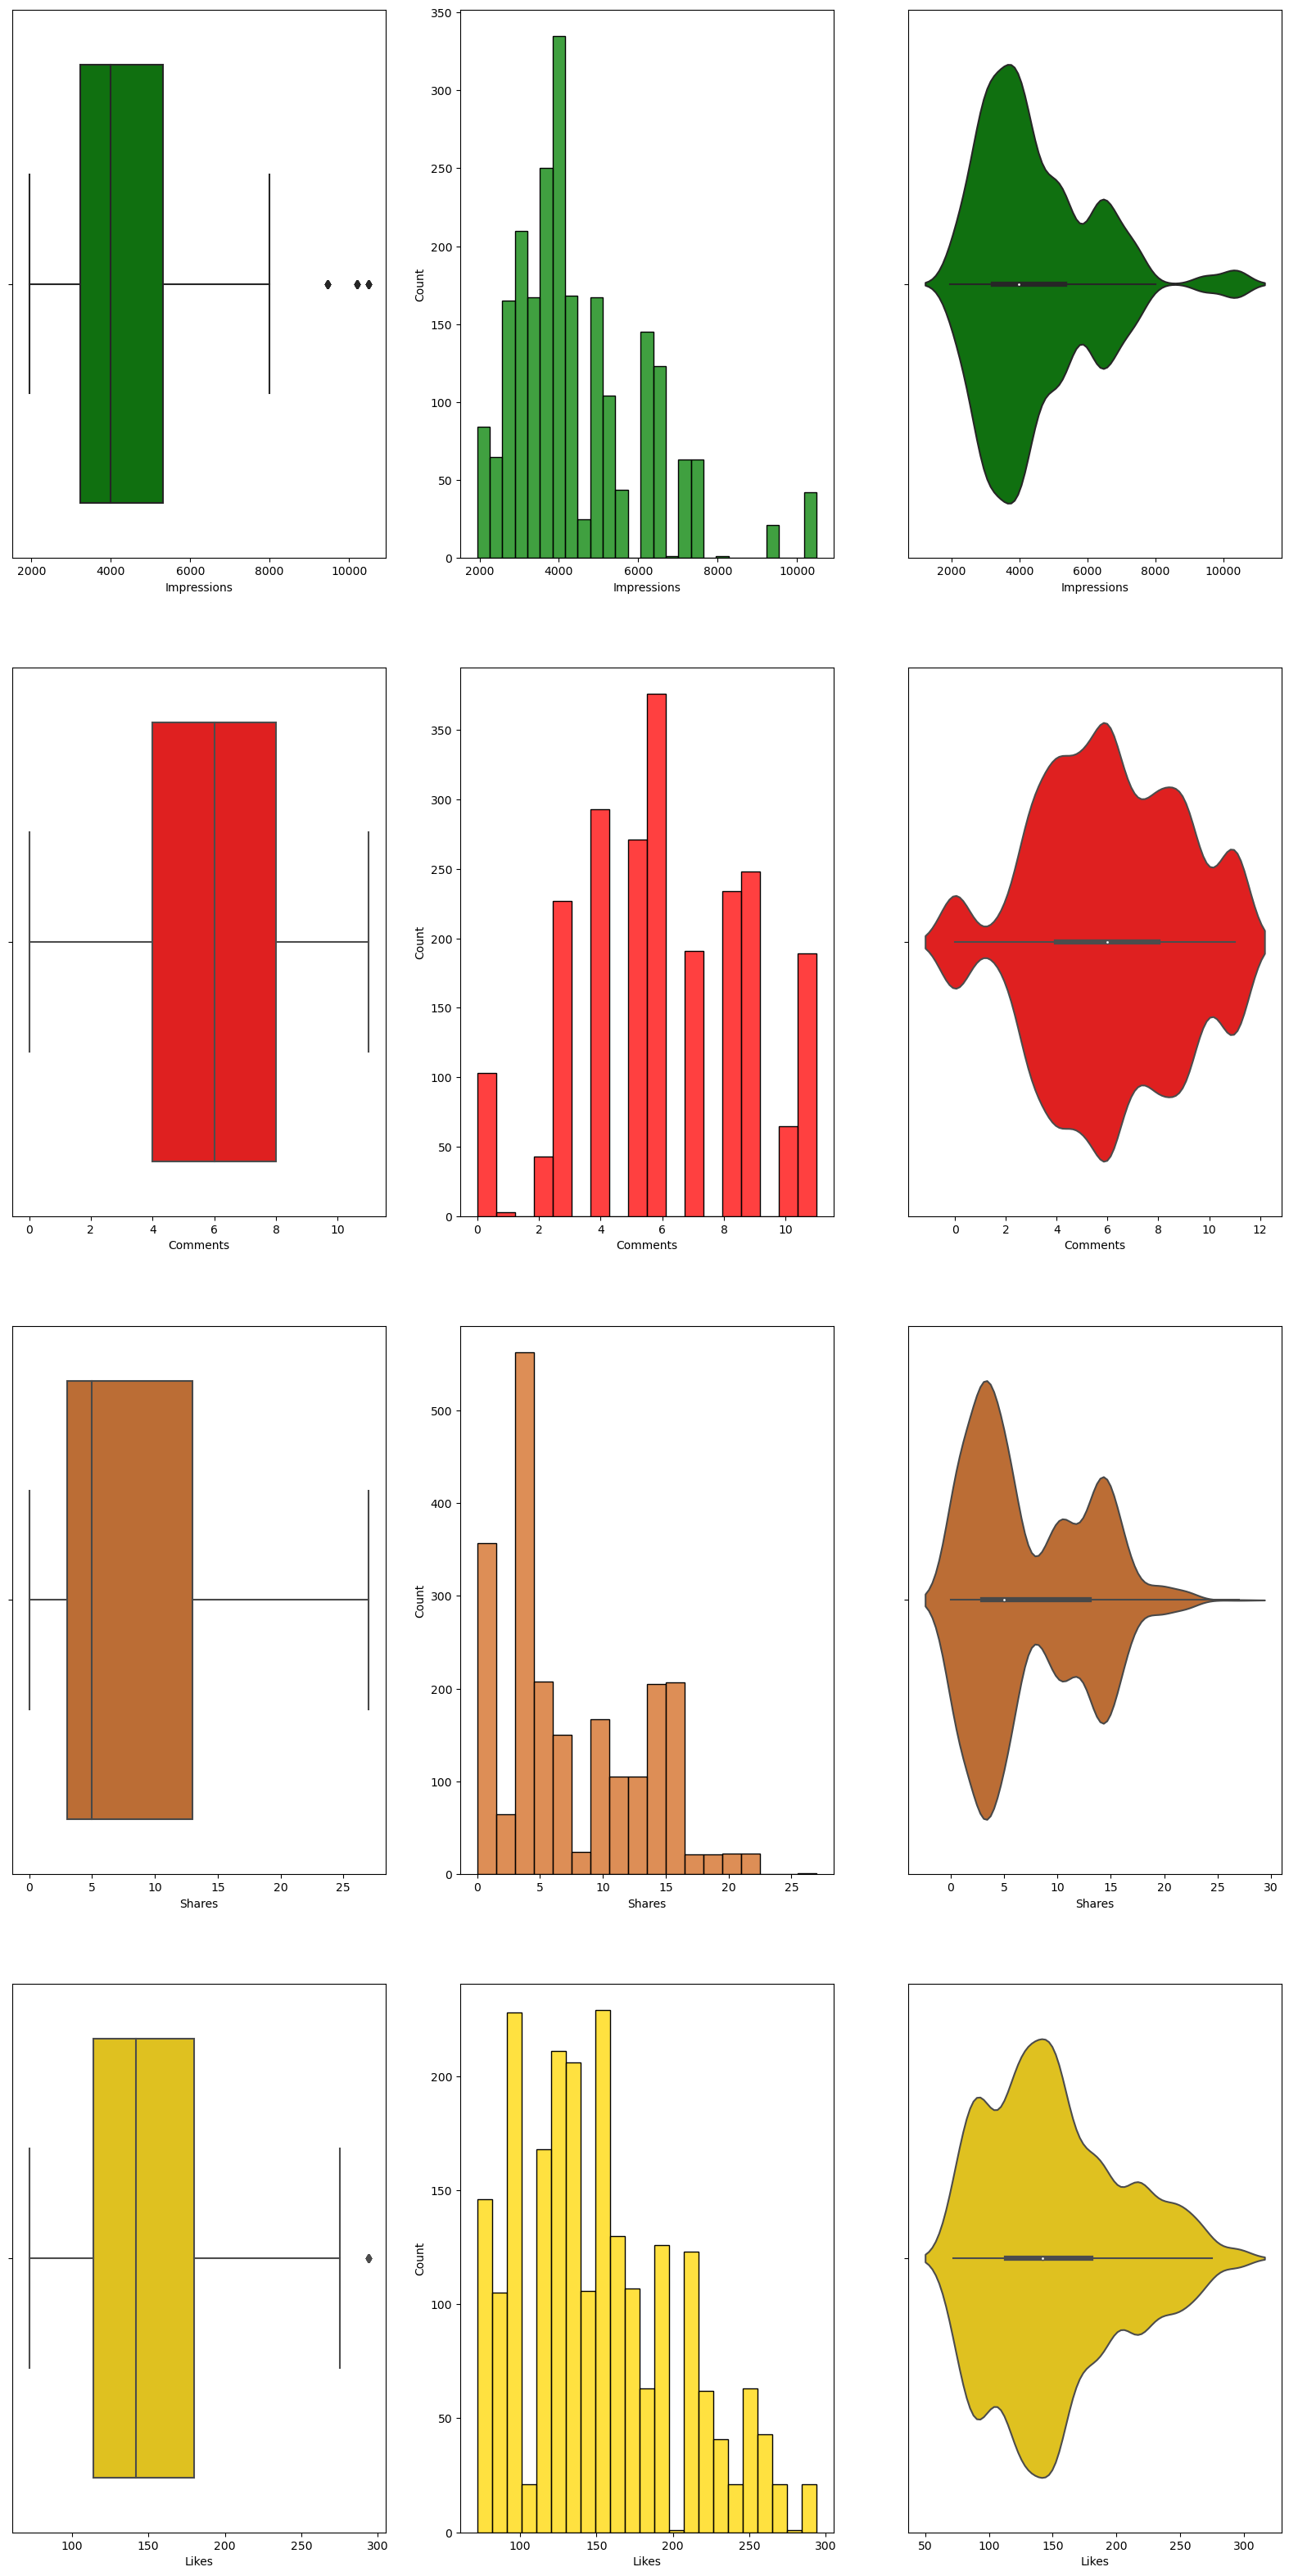

In [ ]:
# Draw the distribution of cleaned numerical variables 
f, axes = plt.subplots(4,3, figsize=(20,40))
colours = ['green', 'red', 'chocolate', 'gold']

count = 0
for i in range(4):
    sb.boxplot(x = data[data_cols[i]], orient = 'h', color = colours[count], ax = axes[count,0])
    sb.histplot(x = data[data_cols[i]], color = colours[count], ax = axes[count,1])
    sb.violinplot(x = data[data_cols[i]], color = colours[count], ax = axes[count,2])
    count+=1

In [ ]:
data.to_csv("Datasets/BootstrappedAndNoOutlier.csv")